# Similarity of sentences

In [1]:
# Dependecies
from ast import literal_eval

from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt

import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from transformers import AutoTokenizer, AutoModelForMaskedLM

from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
# import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

/var/folders/dy/xr0vlym16y5cwngj_4p43nd40000gn/T/ipykernel_63133/2074201164.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/diegoacosta/Documents/Maestría/Thesis/Notebooks/Complete/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [2]:
df_ecoas=pd.read_csv('df_ready.csv', index_col=0)
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,6.3,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",8.8,"['saber', 'muchísimo', 'tema', 'preparado']"
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,94.981,0.0,2,buena maestra si lo recomiendo,10.0,"['buen', 'maestro', 'si', 'recomer']"
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,9.0,"['conocimiento', 'tema']"


In [3]:
df_ecoas['Lemm'] = df_ecoas['Lemm'].apply(literal_eval)
commentsL = df_ecoas['Lemm']
# Merge comments
comentarios_merge=[None]*len(commentsL)
for i in range(len(commentsL)):
  comentarios_merge[i]=(TreebankWordDetokenizer().detokenize(list(commentsL[i])))

comentarios_merge[2]

'saber muchísimo tema preparado'

In [4]:
nltk.download('stopwords')
stop = stopwords.words('spanish')
stop.remove('no')
stop.append('es')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoacosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# This are the questions we will use to compare the comments and obtain the most similar ones
aspects = ['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM']

# Aspects descriptions for the students point of view
MET_student = 'Como estudiante, valoro cuando los profesores utilizan metodologías y actividades de aprendizaje que me brindan explicaciones claras y precisas. Aprecio especialmente el uso de medios y técnicas innovadoras, como herramientas tecnológicas, que hacen el aprendizaje más accesible y atractivo. Estas estrategias no solo facilitan mi comprensión de los temas, sino que también estimulan mi curiosidad y deseo de explorar más allá de lo básico, apoyando eficazmente mi proceso educativo'
PRA_student = 'La posibilidad de aplicar en la práctica lo que aprendo en teoría es fundamental para mí. A través de la resolución de casos reales, proyectos, y prácticas en laboratorios o talleres, siento que mi educación cobra sentido. Visitar empresas y organizaciones o interactuar con profesionales que aplican los temas discutidos en clase me ayuda a comprender mejor cómo se utilizan estos conceptos en el mundo real, preparándome para mi futuro profesional'
ASE_student = 'La interacción con mi profesor y la asesoría que recibo son clave para mi aprendizaje. Cuando un profesor está disponible para resolver mis dudas, ya sea en horarios convenidos o a través de medios digitales, me siento más apoyado y confiado en mi proceso educativo. Un ambiente de aprendizaje respetuoso y abierto, donde puedo expresar mis opiniones y preguntas sin temor, es esencial para mi desarrollo académico y personal'
EVA_student = 'El sistema de evaluación me ayuda a entender mis fortalezas y debilidades dentro del curso. Aprecio cuando se utilizan diversas herramientas de evaluación que ofrecen retroalimentación constructiva, basadas en criterios claros y justos. Esta retroalimentación me permite identificar áreas de mejora y reconocer mis logros, guiándome hacia un aprendizaje más efectivo y personalizado'
RET_student = 'Me siento genuinamente motivado cuando los desafíos intelectuales me exigen dar lo mejor de mí. Los retos que me llevan a cuestionar lo que sé y a esforzarme por entender y aplicar conceptos complejos enriquecen mi experiencia educativa. Este nivel de exigencia no solo impulsa mi crecimiento académico, sino que también fomenta mi desarrollo personal, preparándome para enfrentar futuros desafíos con confianza.'
APR_student = 'Cuando un profesor actúa como guía en mi aprendizaje, inspirándome y demostrando un compromiso genuino con mi desarrollo, siento que mi educación se personaliza y profundiza. Esta actitud no solo me motiva a aprender más, sino que también me enseña la importancia del compromiso y la pasión por el conocimiento. Un educador que guía, desafía e inspira es fundamental para mi crecimiento integral como estudiante'
DOM_student = 'El dominio de la materia por parte de mi profesor es imprescindible. Cuando un educador tiene un profundo conocimiento y experiencia en el tema que enseña, las clases son más claras, interesantes y relevantes. Este dominio permite al profesor conectar los conceptos con la vida real, despertando mi curiosidad y fomentando un aprendizaje más significativo. Además, un profesor que realmente entiende su materia puede adaptar la enseñanza a las necesidades de sus estudiantes, enriqueciendo nuestra experiencia educativa.'

questions = [MET_student, PRA_student, ASE_student, EVA_student, RET_student, APR_student, DOM_student]

print('Aspect descriptions as student POV:', questions)

Aspect descriptions as student POV: ['Como estudiante, valoro cuando los profesores utilizan metodologías y actividades de aprendizaje que me brindan explicaciones claras y precisas. Aprecio especialmente el uso de medios y técnicas innovadoras, como herramientas tecnológicas, que hacen el aprendizaje más accesible y atractivo. Estas estrategias no solo facilitan mi comprensión de los temas, sino que también estimulan mi curiosidad y deseo de explorar más allá de lo básico, apoyando eficazmente mi proceso educativo', 'La posibilidad de aplicar en la práctica lo que aprendo en teoría es fundamental para mí. A través de la resolución de casos reales, proyectos, y prácticas en laboratorios o talleres, siento que mi educación cobra sentido. Visitar empresas y organizaciones o interactuar con profesionales que aplican los temas discutidos en clase me ayuda a comprender mejor cómo se utilizan estos conceptos en el mundo real, preparándome para mi futuro profesional', 'La interacción con mi p

####  USE: Universal Sentence Encoder

In [6]:
# Examples of USE embeddings
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344456553459167, 0.00048082726425491273, 0.06595247983932495, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808634608983994, -0.016524311155080795, 0.015737805515527725, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833269163966179, -0.0558621808886528, -0.012941497378051281, ...]



In [7]:
# This is a test of the similarity score for USE embeddings
sentence1 = 'Esta es una prueba de similitud de oraciones'
sentence2 = 'Este es un experimento para obtener la similitud coseno entre dos comentarios'

In [8]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

use_embeddings_comments = embed(comentarios_merge)
use_embeddings_questions = embed(questions)

In [9]:
print('Comments embeddings shape', use_embeddings_comments.shape)
print('Questions embeddings shape', use_embeddings_questions.shape)

Comments embeddings shape (96540, 512)
Questions embeddings shape (7, 512)


In [10]:
# Determine the maximum sequence length for questions and answers
max_sequence_length = max(len(use_embeddings_comments[0]), len(use_embeddings_questions[0]))

# Initialize an empty array to store similarity scores
similarity_scores = np.zeros((len(questions), len(comentarios_merge)))

# Calculate cosine similarity for each question-answer pair
for i, question_embedding in enumerate(use_embeddings_questions):
    for j, answer_embedding in enumerate(use_embeddings_comments):
        # Pad the shorter sequence to match the maximum length
        padded_question = np.pad(question_embedding.numpy(), (0, max_sequence_length - len(question_embedding)), 'constant')
        padded_answer = np.pad(answer_embedding.numpy(), (0, max_sequence_length - len(answer_embedding)), 'constant')

        # Calculate cosine similarity between the padded embeddings
        similarity = cosine_similarity([padded_question], [padded_answer])[0][0]
        similarity_scores[i][j] = similarity


In [11]:
similarity_scores

array([[0.60294938, 0.55412954, 0.25313604, ..., 0.54348528, 0.58976012,
        0.54152781],
       [0.62665451, 0.5212484 , 0.27522719, ..., 0.5455308 , 0.5550319 ,
        0.55782741],
       [0.60322666, 0.58820504, 0.289958  , ..., 0.4875536 , 0.58687031,
        0.51271003],
       ...,
       [0.58833194, 0.5336442 , 0.24980125, ..., 0.51842642, 0.50492167,
        0.57650995],
       [0.57177448, 0.48223305, 0.28086859, ..., 0.59523851, 0.5806191 ,
        0.61828399],
       [0.55070394, 0.51556164, 0.32364869, ..., 0.61097407, 0.55345452,
        0.5812155 ]])

In [12]:
use_similarity_scores = similarity_scores.T
use_similarity_scores.shape

(96540, 7)

#### BERT Embeddings

In [13]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [14]:
encoded_questions = tokenizer(
    questions,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

encoded_responses = tokenizer(
    comentarios_merge,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

In [15]:
encoded_questions['input_ids'].shape, encoded_responses['input_ids'].shape

(torch.Size([7, 91]), torch.Size([96540, 128]))

In [16]:
encoded_responses_example = {
    'input_ids': encoded_responses['input_ids'][4],
    'attention_mask': encoded_responses['attention_mask'][4]
}

print(encoded_responses_example)


{'input_ids': tensor([   4, 4764, 2833,    5,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

In [17]:
# Determine the maximum sequence length for questions and answers
max_sequence_length = max(len(encoded_questions['input_ids'][0]), len(encoded_responses['input_ids'][0]))

# Initialize an empty array to store similarity scores
similarity_scores = np.zeros((len(questions), len(comentarios_merge)))

# Calculate cosine similarity for each question-answer pair
for i, question_embedding in enumerate(encoded_questions['input_ids']):
    for j, answer_embedding in enumerate(encoded_responses['input_ids']):
        # Pad the shorter sequence to match the maximum length
        padded_question = np.pad(question_embedding.numpy(), (0, max_sequence_length - len(question_embedding)), 'constant')
        padded_answer = np.pad(answer_embedding.numpy(), (0, max_sequence_length - len(answer_embedding)), 'constant')

        # Calculate cosine similarity between the padded embeddings
        similarity = cosine_similarity([padded_question], [padded_answer])[0][0]
        similarity_scores[i][j] = similarity


In [18]:
# We have the scores for similarity between comment and questions, 6 aspects for 98427 different comments
similarity_scores.shape

(7, 96540)

In [19]:
similarity_scores.T

array([[0.35860164, 0.23781862, 0.32133735, ..., 0.47777719, 0.26744933,
        0.20655711],
       [0.1679013 , 0.07889398, 0.24205906, ..., 0.23217634, 0.0982029 ,
        0.12007971],
       [0.10248931, 0.09859222, 0.17732238, ..., 0.18078429, 0.09750165,
        0.11559857],
       ...,
       [0.22090321, 0.1115929 , 0.21003971, ..., 0.24424138, 0.40309566,
        0.18152546],
       [0.35345888, 0.10115127, 0.25212788, ..., 0.33380891, 0.30778434,
        0.12142035],
       [0.36593734, 0.11835073, 0.20851518, ..., 0.22719398, 0.41681304,
        0.28330817]])

In [20]:
bert_similarity_scores = similarity_scores.T

In [21]:
bert_similarity_scores.shape

(96540, 7)

# Plot the range of values for the different embeddings

#### USE

In [22]:
print(np.max(use_similarity_scores))

0.7555310130119324


In [23]:
print(np.min(use_similarity_scores))

-0.14305752515792847


In [24]:
max_values_use = np.max(use_similarity_scores, axis=1)
max_values_use

array([0.62818843, 0.58820504, 0.32364869, ..., 0.61097407, 0.58976012,
       0.61828399])

In [25]:
print(np.min(max_values_use)) # The minimum value from the max values is almost 0, this means that the comments are not similar to the questions

-0.07500699907541275


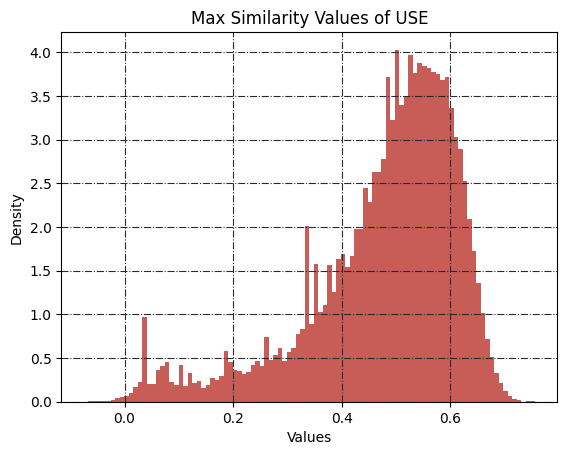

In [42]:
plt.hist(max_values_use, bins=100, density=True, color='#C75D56')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Max Similarity Values of USE')
plt.grid(color='#282A33', linestyle='-.')
plt.show()

In [27]:
print('The mean and std of the max values\nmean:', np.round(np.mean(max_values_use),2), '\nstd:',np.round(np.std(max_values_use),2))

The mean and std of the max values
mean: 0.48 
std: 0.14


In [28]:
range(use_similarity_scores.shape[0])

range(0, 96540)

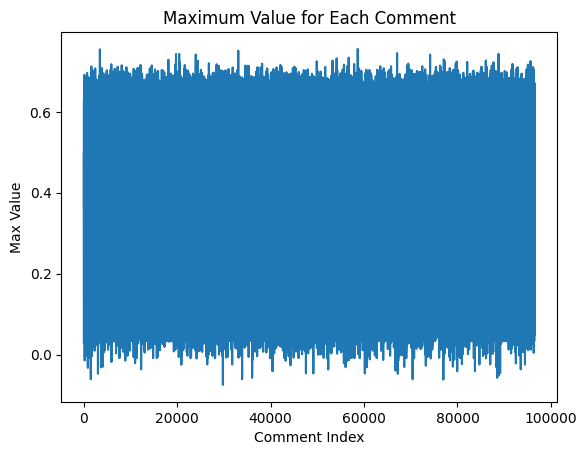

In [29]:
plt.plot(range(use_similarity_scores.shape[0]), max_values_use)
plt.xlabel('Comment Index')
plt.ylabel('Max Value')
plt.title('Maximum Value for Each Comment')
plt.show()


#### BERT

In [30]:
print(np.max(bert_similarity_scores))

0.717381473578131


In [31]:
print(np.min(bert_similarity_scores))

0.013375986672960298


In [32]:
max_values_bert = np.max(bert_similarity_scores, axis=1)
max_values_bert

array([0.47777719, 0.24205906, 0.18078429, ..., 0.40309566, 0.35345888,
       0.41681304])

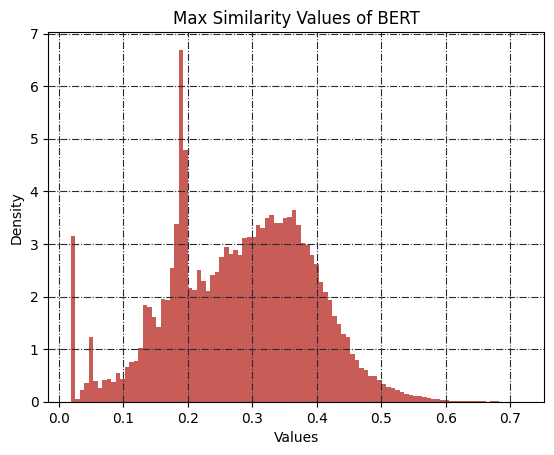

In [33]:
plt.hist(max_values_bert, bins=100, density=True, color='#C75D56')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Max Similarity Values of BERT')
plt.grid(color='#282A33', linestyle='-.')
plt.show()

In [34]:
print('The mean and std of the max values\nmean:', np.round(np.mean(max_values_bert),2), '\nstd:',np.round(np.std(max_values_bert),2))

The mean and std of the max values
mean: 0.28 
std: 0.11


In [35]:
print(np.min(max_values_bert)) # The minimum value from the max values is almost 0, this means that the comments are not similar to the questions

0.018407024613106202


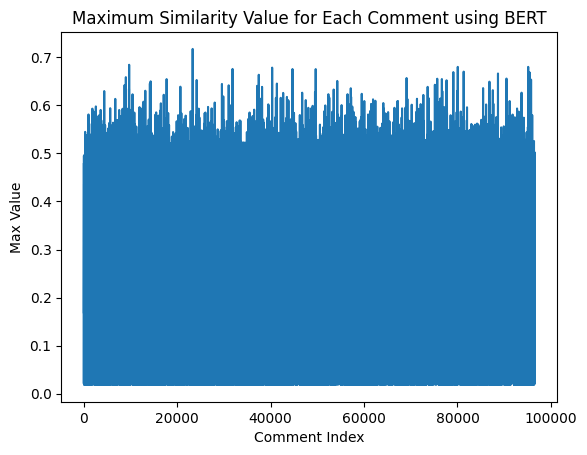

In [36]:
plt.plot(range(bert_similarity_scores.shape[0]), max_values_bert)
plt.xlabel('Comment Index')
plt.ylabel('Max Value')
plt.title('Maximum Similarity Value for Each Comment using BERT')
plt.show()


# Now lets plot the range of values of both BERT and USE embeddings

In [37]:
max_values_use.shape

(96540,)

In [38]:
max_values_bert.shape

(96540,)

In [39]:
range_bert = np.array([np.max(max_values_bert), np.min(max_values_bert)])
range_use = np.array([np.max(max_values_use), np.min(max_values_use)])

In [40]:
print('The range of values for bert is: ', range_bert[0]-range_bert[1])
print('The range of values for use is: ', range_use[0]-range_use[1])

The range of values for bert is:  0.6989744489650248
The range of values for use is:  0.8305380120873451


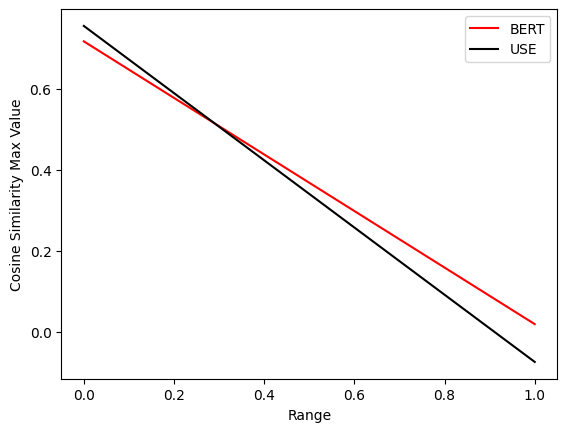

In [44]:
plt.plot(range_bert, c='r', label='BERT')
plt.plot(range_use, c='black', label='USE')
plt.legend()

plt.xlabel('Range')
plt.ylabel('Cosine Similarity Max Value')
plt.show()
